In [1]:
%pip install umap-learn hdbscan geopandas

     |████████████████████████████████| 81kB 3.2MB/s 
     |████████████████████████████████| 6.4MB 7.8MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 1.0MB 30.1MB/s 
     |████████████████████████████████| 1.2MB 29.7MB/s 
     |████████████████████████████████| 6.6MB 28.8MB/s 
     |████████████████████████████████| 15.4MB 242kB/s 
  Created wheel for hdbscan: filename=hdbscan-0.8.27-cp37-cp37m-linux_x86_64.whl size=2311678 sha256=efd04dffa46c8a3de6630b7a1111835d588a378998b0d7e00de46e6f649a901f
  Stored in directory: /root/.cache/pip/wheels/42/63/fb/314ad6c3b270887a3ecb588b8e5aac50b0fad38ff89bb6dff2
Successfully built hdbscan
  Created wheel for umap-learn: filename=umap_learn-0.5.1-cp37-none-any.whl size=76569 sha256=7786c300eba7547d6a6302d186caaf16e68ae36e08642f869ceea401bb99aa80
  Stored in directory: /root/.cache/pip/wheels/ad/df/d5/a3691296ff779f25cd1cf415a3

## Import

In [2]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import datetime
import geopandas as gpd
import umap
import hdbscan
import json
from calendar import monthrange

from math import sqrt, ceil
from scipy.stats import zscore
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## Compute mapping between city and country

In [4]:
df_original = pd.read_csv(os.path.join('Data','european_cities.csv'))
df_original = df_original[:55]
countries_mapping = df_original.set_index('City')['Country'].to_dict()

## Load light data

In [5]:
df_light = pd.read_csv(os.path.join('Data','european_cities_light.csv'), index_col="Unnamed: 0")
col = df_light.columns
col_datetime = [datetime.date.fromisoformat(i) for i in col]
df_light.columns = col_datetime

In [7]:
class LightModel():
  def __init__(self):
    self.score_by_city = {}
    self.month_values_by_city = {}
    self.covid_years_by_city = {}

  def fit_predict(self, X):
    self.X = X
    i = 0
    for index, row in self.X .iterrows():
      no_covid_year = row.loc[datetime.date.fromisoformat('2014-01-01'):datetime.date.fromisoformat('2019-12-01')]
      df = pd.DataFrame(no_covid_year)
      df.columns = ['light']
      df['month'] = pd.DatetimeIndex(df.index).month

      covid_year = row.loc[datetime.date.fromisoformat('2020-01-01'):datetime.date.fromisoformat('2020-12-01')].to_list()

      city_score = 0
      month_values = {}
      for month in range(1,13):
        values = df[df['month'] == month]['light'].to_list()
        mean = np.mean(values)
        std = np.std(values)
        month_values[month] = (mean, std)
        if covid_year[month-1] > (mean + std) or covid_year[month-1] < (mean-std):
          city_score += 1

      self.month_values_by_city[index] = month_values
      self.score_by_city[index] = city_score
      self.covid_years_by_city[index] = covid_year

    return self.score_by_city

  def get_country_scores(self, mapping_dict):
    score_by_country = {}

    for city, value in self.score_by_city.items():
      country = mapping_dict[city]
      if country not in score_by_country:
        score_by_country[country] = list()
      score_by_country[country].append(value)

    for key, value in score_by_country.items():
      score_by_country[key] = np.mean(value)

    return score_by_country

  def display(self):
    size_plot = ceil(sqrt(len(self.X)))
    fig, axes = plt.subplots(ncols=size_plot, nrows=size_plot, figsize=(24,14))
    axes = axes.flatten()

    i=0
    for city, dict_month in self.month_values_by_city.items():

      mean, std = zip(*dict_month.values())
      mean = np.array(mean)
      std = np.array(std)

      axes[i].fill_between(range(1,13), mean - std, mean + std, alpha=0.5, label="2014-2019 range")
      axes[i].plot(range(1,13), self.covid_years_by_city[city], c='r', label="2020")
      axes[i].set_title(city)
      axes[i].set_xticks(range(1,13))
      if i == len(self.X) - 1:
        axes[i].legend()

      i+=1

    for index_ax in range(len(axes) - i):
      axes[len(axes) - index_ax - 1].axis('off')

    fig.tight_layout()


## Compute light ranking 

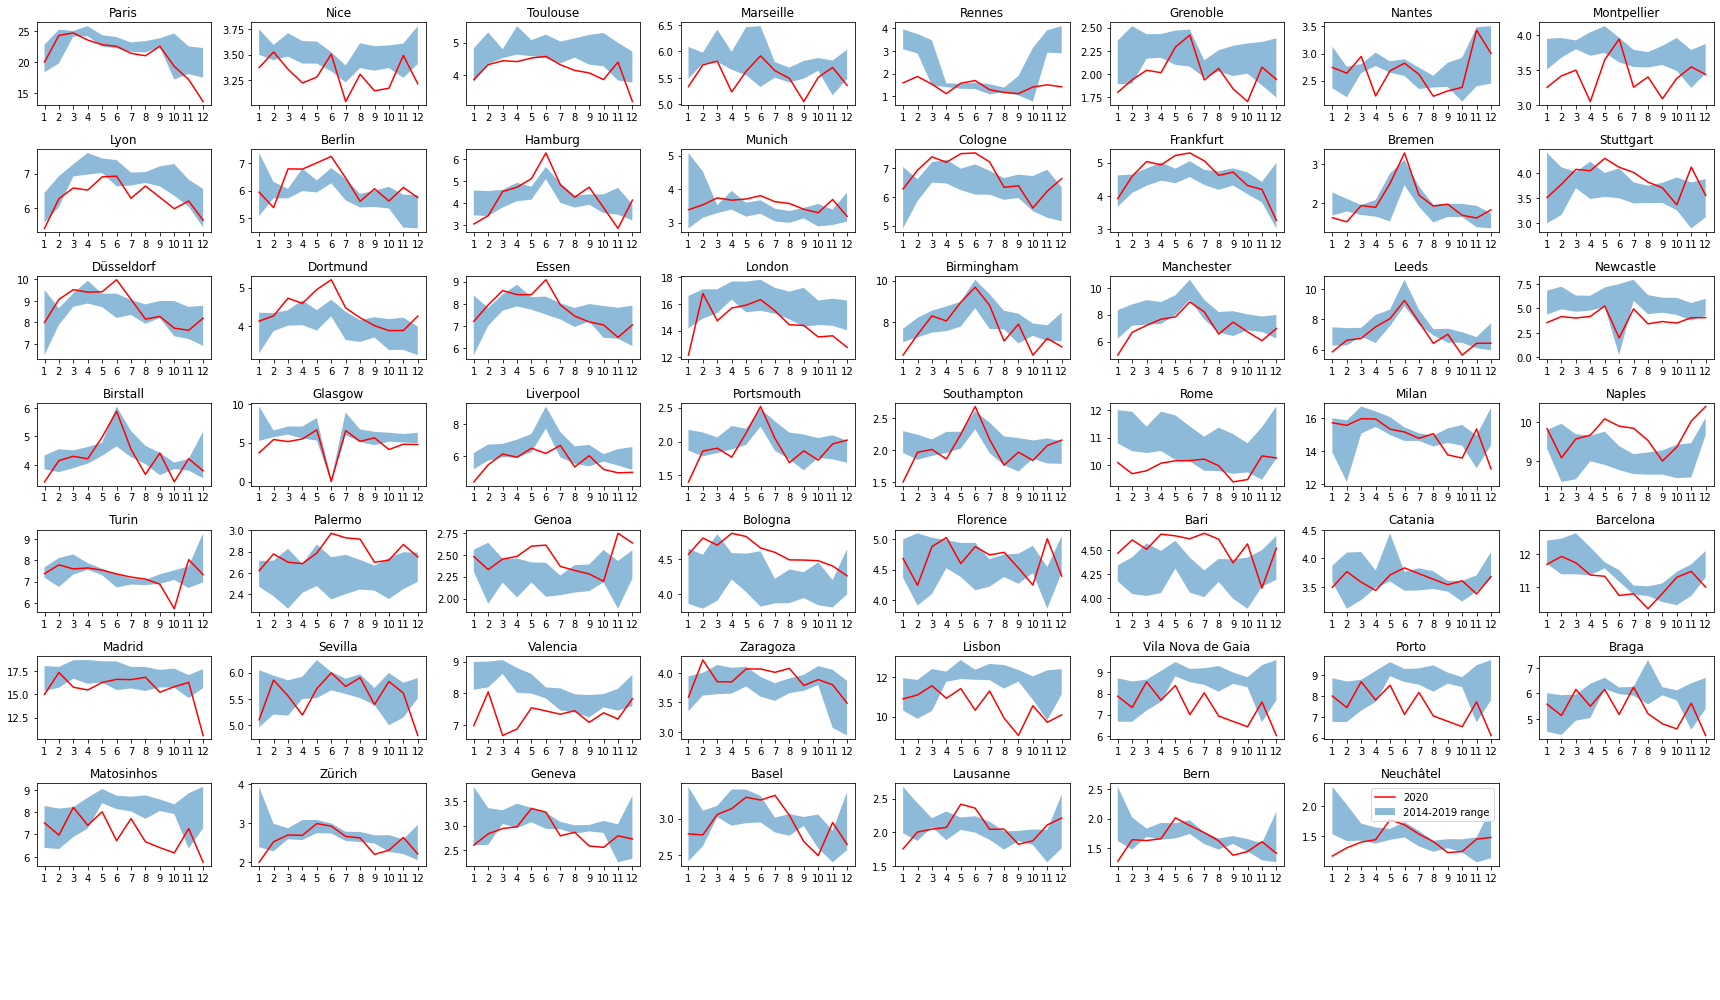

In [8]:
lm = LightModel()
score_by_city = lm.fit_predict(df_light)
lm.display()
score_by_country = lm.get_country_scores(countries_mapping)

## Define uniform dict for mapping color and countries

In [ ]:
dict_colors = {
    'France' : 'b',
    'FRA' : 'b',
    'Germany' : 'c' ,
    'DEU' : 'c',
    'Italy': 'm',
    'ITA':'m',
    'Portugal' : 'g',
    'PRT':'g',
    'Spain':'r',
    'ESP':'r',
    'Switzerland': 'k',
    'CHE' : 'k',
    'United Kingdom':'y',
    'GBR':'y'
 }

## Score by country plot

Text(0.5, 1.0, 'Score by country')

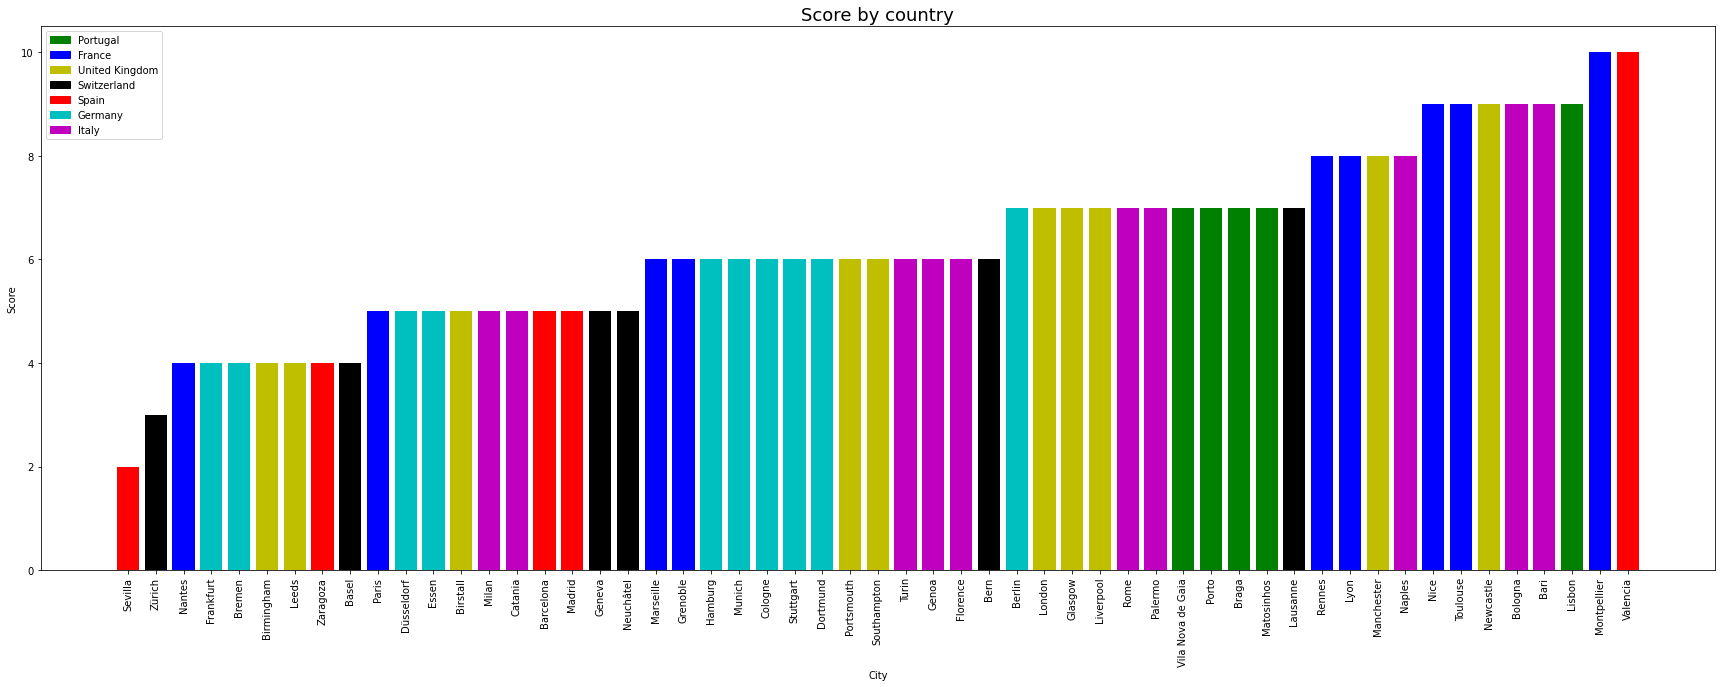

In [ ]:
score_by_city = dict(sorted(score_by_city.items(), key=lambda item: item[1]))

list_colors = [dict_colors[countries_mapping[c]] for c in score_by_city.keys()]
list_countries = [countries_mapping[c] for c in score_by_city.keys()]

fig, ax = plt.subplots(figsize=(30,10))
ax.bar(score_by_city.keys(), score_by_city.values(), color=list_colors)
ax.tick_params(axis='x', rotation=90)
ax.set_ylabel("Score")
ax.set_xlabel("City")

handles = [plt.Rectangle((0,0),1,1, color=dict_colors[label]) for label in list(set(list_countries))]
ax.legend(handles, list(set(list_countries)))
ax.set_title("Score by country", fontsize=18)

## Plot of normalized light value
The goal here is to verify the variability of the normalized light intensity of cities in relation to each other.

Text(0, 0.5, 'Normalized light value')

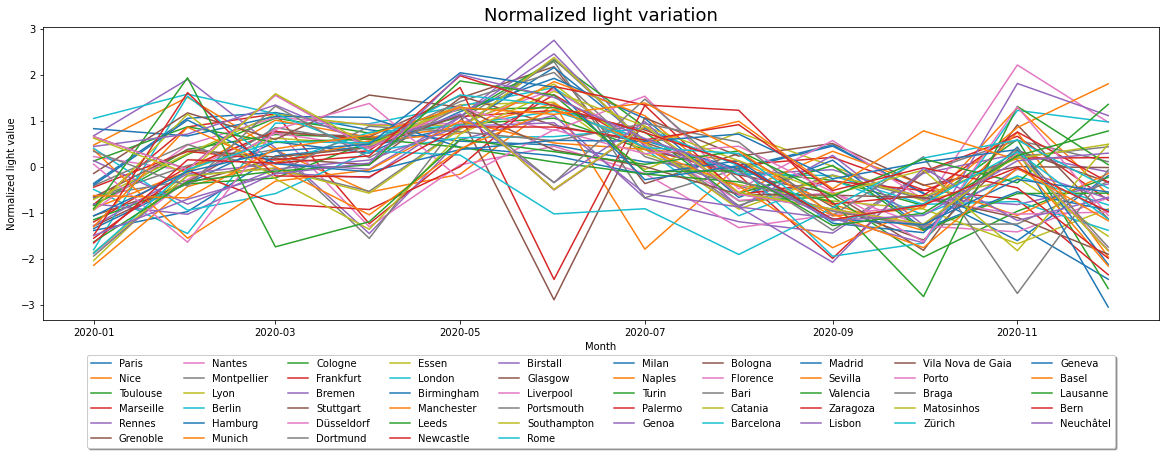

In [ ]:
df_norm = df_light.T.loc[datetime.date.fromisoformat('2020-01-01'):datetime.date.fromisoformat('2020-12-01')].T
df_norm = df_norm.T.apply(zscore, axis=0).T

fig, ax = plt.subplots(figsize=(20,6))
df_norm.T.plot(ax=ax)
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=10)

ax.set_title("Normalized light variation", fontsize=18)
ax.set_xlabel("Month")
ax.set_ylabel("Normalized light value")

## Plot output of UMAP and TSNE reduction

In [ ]:
umap_embedding = umap.UMAP().fit_transform(df_norm.to_numpy())

In [ ]:
tsne_embedding = TSNE(n_components=2).fit_transform(df_norm.to_numpy())

Text(0.5, 1.0, 'Scatter plot countries - TSNE')

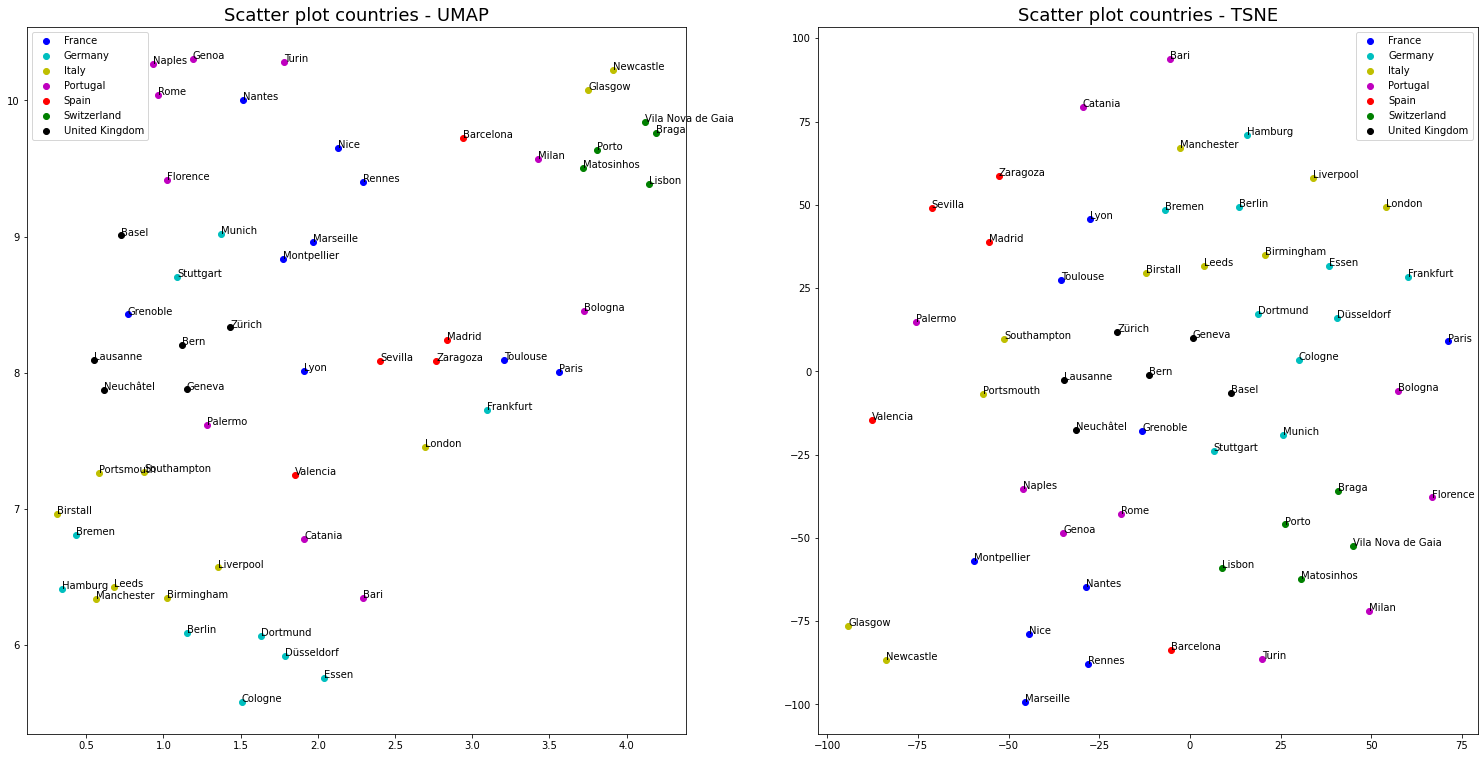

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(26,13))

cities = df_norm.index
x,y = zip(*umap_embedding)

for i, coord in enumerate(zip(umap_embedding)):
  country = countries_mapping[cities[i]]
  axes[0].scatter(coord[0][0], coord[0][1], color=dict_colors[country])

for i, coord in enumerate(zip(tsne_embedding)):
  country = countries_mapping[cities[i]]
  axes[1].scatter(coord[0][0], coord[0][1], color=dict_colors[country])

x_umap,y_umap = zip(*umap_embedding)
x_tsne,y_tsne = zip(*tsne_embedding)


for i, city in enumerate(cities):
  axes[0].annotate(city, (x_umap[i], y_umap[i]))
  axes[1].annotate(city, (x_tsne[i], y_tsne[i]))

leg0 = axes[0].legend([c for c in dict_colors.keys() if len(c) !=3])
leg1 = axes[1].legend([c for c in dict_colors.keys() if len(c) !=3])
i=0

for c, l in zip(colors, leg0.legendHandles):
  leg0.legendHandles[i].set_color(c)
  leg1.legendHandles[i].set_color(c)
  i+=1

axes[0].set_title("Scatter plot countries - UMAP",fontsize=18)
axes[1].set_title("Scatter plot countries - TSNE",fontsize=18)

## HDBSCAN on UMAP embeddings

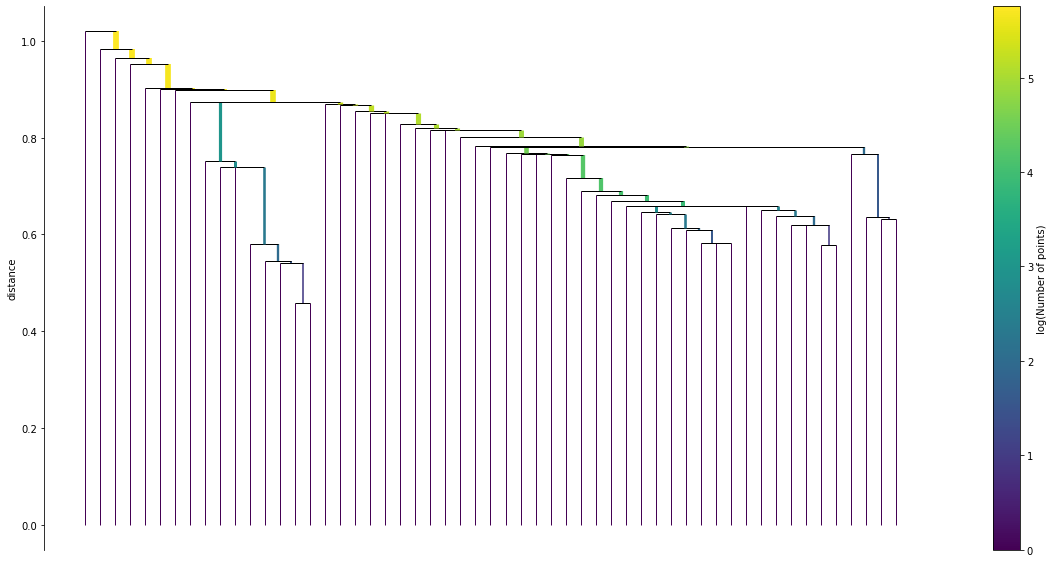

In [ ]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=5)
cluster_umap = clusterer.fit_predict(umap_embedding)

fig, ax = plt.subplots(figsize=(20,10))
clusterer.single_linkage_tree_.plot(cmap='viridis', colorbar=True, axis=ax)

## KMeans on umap output

In [ ]:
kmeans = KMeans(n_clusters=5).fit(umap_embedding)
kmeans.labels_

array([3, 0, 3, 0, 0, 2, 0, 0, 2, 4, 4, 0, 4, 3, 4, 2, 4, 4, 4, 3, 4, 4,
       4, 1, 4, 1, 4, 2, 2, 0, 1, 0, 0, 2, 0, 3, 0, 4, 4, 1, 3, 3, 2, 3,
       1, 1, 1, 1, 1, 2, 2, 0, 2, 2, 2], dtype=int32)

Text(0.5, 1.0, 'Kmeans output for UMAP embeddings')

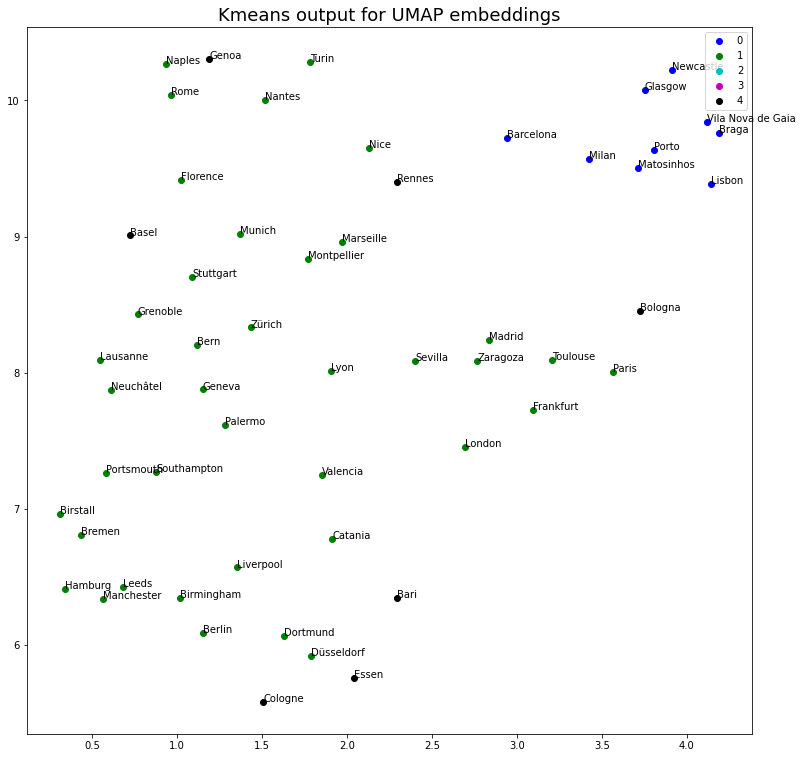

In [ ]:
colors = ['b', 'g', 'c', 'm', 'k']

fig, ax = plt.subplots(figsize=(13,13))
x,y = zip(*umap_embedding)
for i, coord in enumerate(zip(umap_embedding)):
  country = countries_mapping[cities[i]]
  ax.scatter(coord[0][0], coord[0][1], color=colors[cluster[i]])

for i, city in enumerate(cities):
  ax.annotate(city, (x[i], y[i]))

leg = ax.legend([0,1,2,3,4])
for c, l in zip(colors, leg.legendHandles):
  l.set_color(c)

ax.set_title("Kmeans output for UMAP embeddings", fontsize=18)

## Correlation between covid cases/deaths and light variation
### Get covid cases/deaths for each country

In [ ]:
COUNTRIES = ['FRA', 'DEU', 'ITA', 'PRT', 'ESP', 'CHE', 'GBR']

#population = pd.read_csv(os.path.join('Data','population.csv'))

with open(os.path.join('Data','covid.json')) as json_file:
  data = json.load(json_file)

  df_cases_country = pd.DataFrame()
  df_deaths_country = pd.DataFrame()

  for country in COUNTRIES:
    cases_month = {}
    deaths_month = {}
    acc_case = 0.0
    acc_death = 0.0

    for item in data[country]['data']:
      year, month, day = int(item['date'].split('-')[0]), int(item['date'].split('-')[1]), int(item['date'].split('-')[2])
      if year==2020:
        acc_case += item['new_cases_per_million'] if 'new_cases_per_million' in item else 0.0
        acc_death += item['new_deaths_per_million'] if 'new_deaths_per_million' in item else 0.0
        if monthrange(year, month)[1] == day:
          cases_month[datetime.date(year, month, 1)] = acc_case
          deaths_month[datetime.date(year, month, 1)] = acc_death
          acc_case=0.0
          acc_death=0.0
    
    df_covid = pd.DataFrame.from_dict(cases_month, orient='index',columns=[country])
    df_covid.index.name = 'date'
    df_cases_country = pd.concat([df_cases_country, df_covid], axis=1)

    df_death = pd.DataFrame.from_dict(deaths_month, orient='index',columns=[country])
    df_death.index.name = 'date'
    df_deaths_country = pd.concat([df_deaths_country, df_death], axis=1)

df_cases_country = df_cases_country.fillna(0)
df_cases_country = df_cases_country.T

df_deaths_country = df_deaths_country.fillna(0)
df_deaths_country = df_deaths_country.T

In [ ]:
cases_sum = df_cases_country.sum(axis=1)
deaths_sum = df_deaths_country.sum(axis=1)

### Covid cases, deaths and country score plots

Text(0.5, 1.0, 'Ranking score by country')

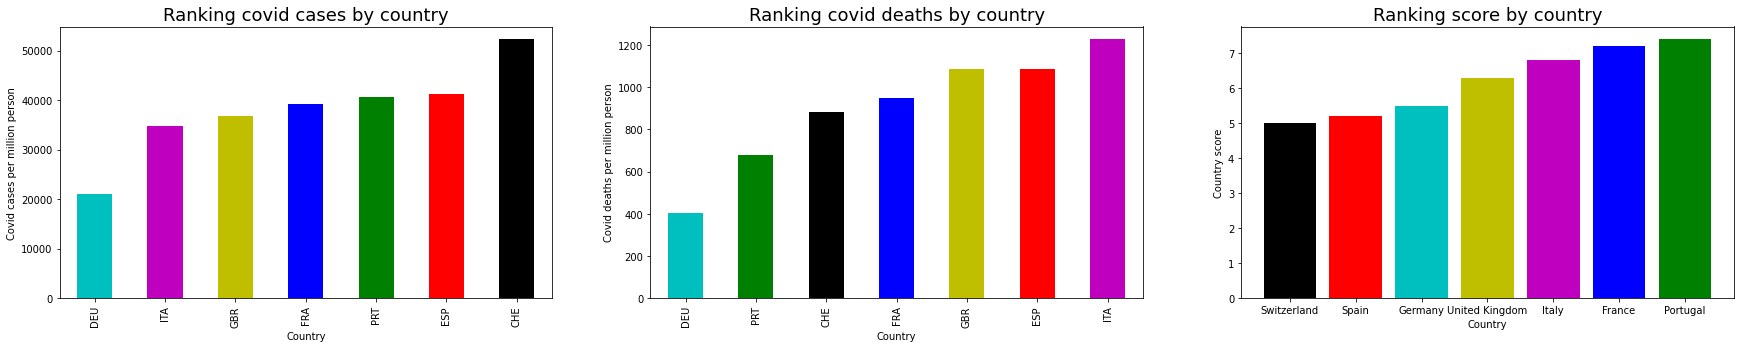

In [ ]:
fig, axes = plt.subplots(1,3,figsize=(30,5))
cases_sum.sort_values().plot.bar(ax=axes[0], color=[dict_colors[label] for label in cases_sum.sort_values().index.tolist()])
axes[0].set_xlabel('Country')
axes[0].set_ylabel('Covid cases per million person')
axes[0].set_title('Ranking covid cases by country', fontsize=18)

deaths_sum.sort_values().plot.bar(ax=axes[1], color=[dict_colors[label] for label in deaths_sum.sort_values().index.tolist()])
axes[1].set_xlabel('Country')
axes[1].set_ylabel('Covid deaths per million person')
axes[1].set_title('Ranking covid deaths by country', fontsize=18)

for key, value in score_by_country.items():
  score_by_country[key] = np.mean(value)

score_by_country = {k: v for k, v in sorted(score_by_country.items(), key=lambda item: item[1])}

axes[2].bar(score_by_country.keys(), score_by_country.values(), color=[dict_colors[label] for label in score_by_country.keys()])
axes[2].set_xlabel('Country')
axes[2].set_ylabel('Country score')
axes[2].set_title('Ranking score by country', fontsize=18)

In [ ]:
stringency_index = pd.read_csv(os.path.join("Data", "covid-stringency-index.csv"))
stay_home_index = pd.read_csv(os.path.join("Data", "stay-at-home-covid.csv"))
school_closure_index = pd.read_csv(os.path.join("Data", "school-closures-covid.csv"))
workspace_closure_index = pd.read_csv(os.path.join("Data", "workplace-closures-covid.csv"))
public_event_index = pd.read_csv(os.path.join("Data", "public-events-covid.csv"))
public_gathering_index = pd.read_csv(os.path.join("Data", "public-gathering-rules-covid.csv"))

Text(0.5, 1.0, 'Correlation gathering index and light index')

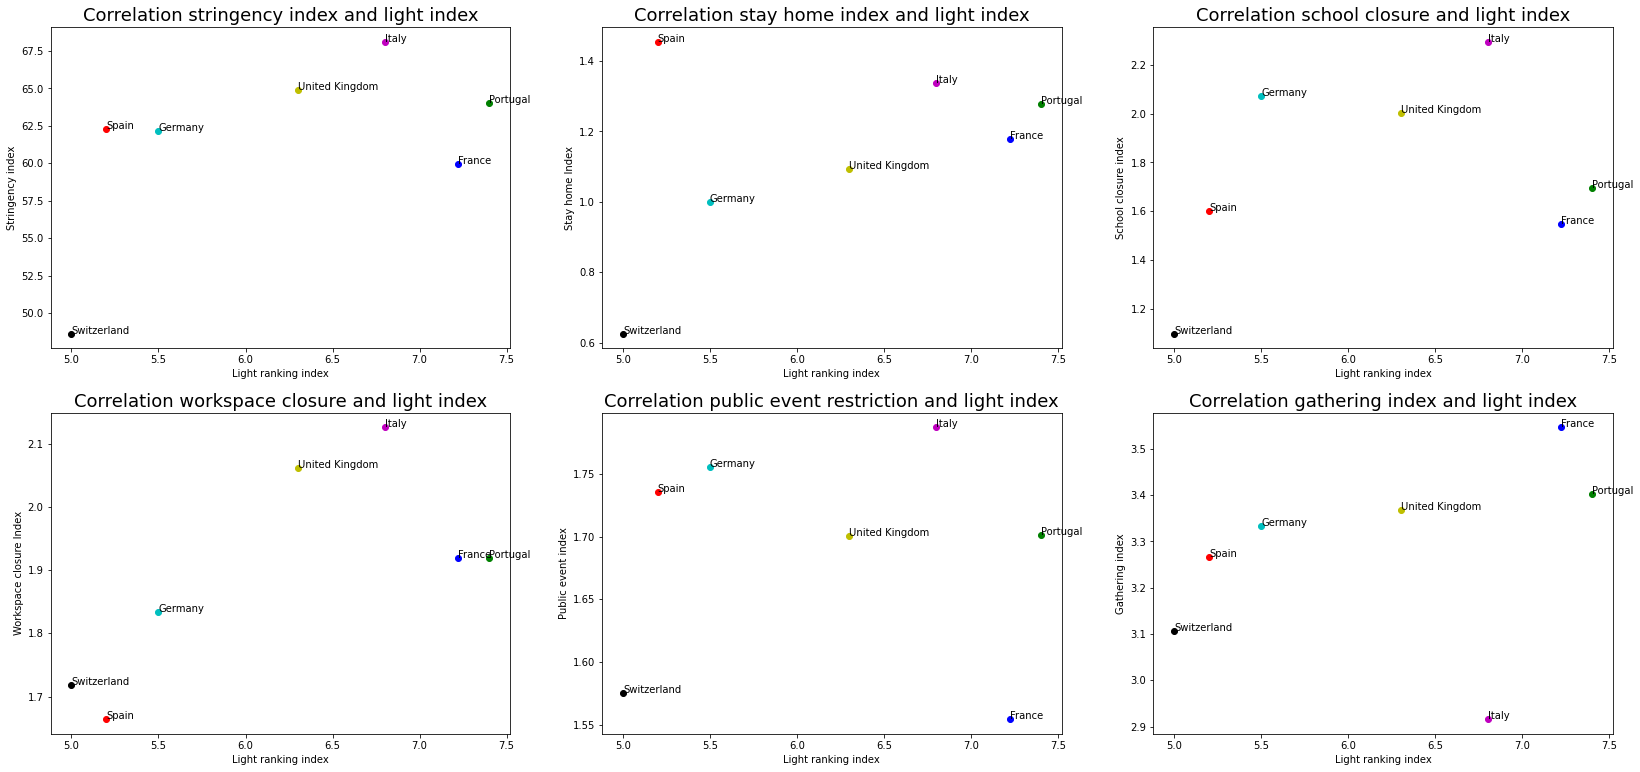

In [ ]:
fig, axes = plt.subplots(2,3,figsize=(28,13))
axes = axes.flatten()

for country in score_by_country.keys():
  x = score_by_country[country]
  y_stringency = np.mean(stringency_index[stringency_index['Entity'] == country]['stringency_index'].to_numpy())
  y_school_closure = np.mean(school_closure_index[school_closure_index['Entity'] == country]['school_closures'].to_numpy())
  y_workspace_closure  = np.mean(workspace_closure_index[workspace_closure_index['Entity'] == country]['workplace_closures'].to_numpy())
  y_stay_home = np.mean(stay_home_index[stay_home_index['Entity'] == country]['stay_home_requirements'].to_numpy())
  y_public_event = np.mean(public_event_index[public_event_index['Entity'] == country]['cancel_public_events'].to_numpy())
  y_public_gathering = np.mean(public_gathering_index[public_gathering_index['Entity'] == country]['restriction_gatherings'].to_numpy())

  axes[0].annotate(country, (x, y_stringency))
  axes[0].scatter(x,y_stringency, c=dict_colors[country])

  axes[1].annotate(country, (x, y_stay_home))
  axes[1].scatter(x,y_stay_home, c=dict_colors[country])

  axes[2].annotate(country, (x, y_school_closure))
  axes[2].scatter(x,y_school_closure, c=dict_colors[country])

  axes[3].annotate(country, (x, y_workspace_closure))
  axes[3].scatter(x,y_workspace_closure, c=dict_colors[country])

  axes[4].annotate(country, (x, y_public_event))
  axes[4].scatter(x,y_public_event, c=dict_colors[country])

  axes[5].annotate(country, (x, y_public_gathering))
  axes[5].scatter(x,y_public_gathering, c=dict_colors[country])

axes[0].set_xlabel("Light ranking index")
axes[0].set_ylabel("Stringency index")
axes[0].set_title("Correlation stringency index and light index", fontsize=18)

axes[1].set_xlabel("Light ranking index")
axes[1].set_ylabel("Stay home Index")
axes[1].set_title("Correlation stay home index and light index", fontsize=18)

axes[2].set_xlabel("Light ranking index")
axes[2].set_ylabel("School closure index")
axes[2].set_title("Correlation school closure and light index", fontsize=18)

axes[3].set_xlabel("Light ranking index")
axes[3].set_ylabel("Workspace closure Index")
axes[3].set_title("Correlation workspace closure and light index", fontsize=18)

axes[4].set_xlabel("Light ranking index")
axes[4].set_ylabel("Public event index")
axes[4].set_title("Correlation public event restriction and light index", fontsize=18)

axes[5].set_xlabel("Light ranking index")
axes[5].set_ylabel("Gathering index")
axes[5].set_title("Correlation gathering index and light index", fontsize=18)